* Jonathan Leeper
* NBA Player Similarity Project

# NBA Player Similarity Project

For this project, our goals are to find similarity scores of NBA players by using statistics for their season log, and comparing them to seasons of other players, and coming away with similarity scores for each. We will also be evaluating the PCA & K-Means Clusters of that PCA.

## Part 0: Imports

For easier use of this notebook, I will be applying these in this step.

In [1]:
import pandas as pd
import numpy as np
from nba_api.stats.endpoints import leaguedashplayerstats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
import time

## Part 1: Importing Dataset

We will be using **NBA-api** for this step, as it will easily be able to import the correct statistics and functions for this set.

I have also included 3 additional advanced metrics not included in LeagueDashPlayerStats - True Shooting %, Usage %, and PER (Player Efficiency Rating). These are very important in determining the similarity of players while incorporating advanced metrics. How these are determined are talked about below.

In [2]:
def get_nba_player_stats_multi_season(start_year, end_year):
    all_seasons = []
    
    for year in range(start_year, end_year + 1):
        season = f"{year}-{str(year+1)[-2:]}"    
        
        try:
            stats = leaguedashplayerstats.LeagueDashPlayerStats(season=season, per_mode_detailed="PerGame")
            df = stats.get_data_frames()[0]
            
            # Select relevant columns
            df = df[[
                "PLAYER_NAME", "TEAM_ID", "PTS", "REB", "AST", "STL", "BLK", "TOV",  
                "FG_PCT", "FG3_PCT", "FT_PCT", "GP", "MIN", "FGA", "FGM", "FTA", "FTM"
            ]]
            
            # Compute Advanced Metrics
            df["TS_PCT"] = df["PTS"] / (2 * (df["FGA"] + 0.475 * df["FTA"]))  
            df["USG_PCT"] = ((df["FGA"] + (0.44 * df["FTA"]) + df["TOV"] + (0.33 * df["AST"])) * 100) / (df["MIN"] * 3)  
            df["PER"] = (df["PTS"] + df["REB"] + df["AST"] + df["STL"] + df["BLK"] - 
                         (df["FGA"] - df["FGM"]) - (df["FTA"] - df["FTM"]) - df["TOV"]) / df["GP"]
            
            df["SEASON"] = season  
            df = df.dropna()  
            
            all_seasons.append(df)
            
            time.sleep(1)  # Prevent rate-limiting
            
        except Exception as e:
            print(f"Failed to fetch data for {season}: {e}")

    return pd.concat(all_seasons, ignore_index=True)

In [3]:
nba_stats_df = get_nba_player_stats_multi_season(start_year=2000, end_year=2023)

In [4]:
df = nba_stats_df

df['PLAYER'] = df['PLAYER_NAME'] + ', ' + df['SEASON']
df = df.drop(columns=['TEAM_ID', 'PLAYER_NAME', 'SEASON'])
df = df[['PLAYER'] + [col for col in df.columns if col != 'PLAYER']]

print(df.head())

                    PLAYER   PTS  REB  AST  STL  BLK  TOV  FG_PCT  FG3_PCT  \
0      A.C. Green, 2000-01   4.5  3.8  0.5  0.4  0.1  0.5   0.444    0.000   
1     A.J. Guyton, 2000-01   6.0  1.1  1.9  0.3  0.2  0.7   0.406    0.391   
2     Aaron McKie, 2000-01  11.6  4.1  5.0  1.4  0.1  2.7   0.473    0.312   
3  Aaron Williams, 2000-01  10.2  7.2  1.1  0.7  1.4  1.6   0.457    0.000   
4      Adam Keefe, 2000-01   2.5  3.1  0.5  0.4  0.3  0.6   0.403    0.333   

   FT_PCT  GP   MIN  FGA  FGM  FTA  FTM    TS_PCT    USG_PCT       PER  
0   0.712  82  17.2  4.0  1.8  1.4  1.0  0.482315  10.234496  0.075610  
1   0.833  33  19.0  5.8  2.4  0.5  0.5  0.496894  12.889474  0.163636  
2   0.768  76  31.5  9.4  4.4  2.6  2.0  0.545369  15.760847  0.182895  
3   0.787  82  28.5  7.9  3.6  3.8  3.0  0.525502  13.491228  0.169512  
4   0.619  67  12.6  2.4  1.0  0.9  0.6  0.442087   9.420635  0.067164  


In the above code, I have concatenated Player Name & Season, as well as converted to a csv for easier viewing. Also, we would be able to export the df to a csv for future viewing, but that is not necessary in this certain step.

**NOTE:**

When it comes to my advanced statistics, I added in my own True Shooting %, Usage %, and PER. The [True Shooting Percentage](https://resources.wolframcloud.com/FormulaRepository/resources/Basketball-True-Shooting-Percentage) and [The Usage Rate Percentage](https://resources.wolframcloud.com/FormulaRepository/resources/Basketball-Usage-Rate), Showcases that same formula (minus Poss - I used minutes played times 3 to determine this). However, I did need to take liberties when it came to PER. For this, [Basketball-Reference](https://www.basketball-reference.com/about/per.html) Showcases PER by using a very intensive formula. This takes into account the teams totals, the league totals for seasons, and other factors. It is an amazing formula that showcases how extensive NBA statistics can get, but for the sake of this API, I will be using the formula I created above - this takes into account how much activity the player exercises and removes negative statistics such as missed shots and turnovers, and divides them by games played. This, of course, is not as extensive as the official PER, however, it does give us a good baseline for comparisons.

## Part 2: Applying PCA & Computing Similarity

In this step, we will be taking our data & processing it to create similarity patterns.

In [5]:
def preprocess_data(df):
    scaler = StandardScaler()
    numeric_data = df[["PTS", "REB", "AST", "TS_PCT", "USG_PCT", "PER"]]
    normalized_data = scaler.fit_transform(numeric_data)
    
    return pd.DataFrame(normalized_data, columns=["PTS", "REB", "AST", "TS_PCT", "USG_PCT", "PER"], index=df["PLAYER"])

In [6]:
def apply_pca(data, n_components=2):
    pca = PCA(n_components=n_components)
    reduced_data = pca.fit_transform(data)
    
    return pd.DataFrame(reduced_data, columns=[f"PC{i+1}" for i in range(n_components)], index=data.index)

In [7]:
def get_similar_players(player_name, pca_df, top_n=5):
    similarity_matrix = cosine_similarity(pca_df)
    similarity_df = pd.DataFrame(similarity_matrix, index=pca_df.index, columns=pca_df.index)
    
    # Sort similar players
    similar_players = similarity_df[player_name].sort_values(ascending=False).iloc[1:top_n+1]
    
    return similar_players

In [8]:
normalized_df = preprocess_data(df)
pca_df = apply_pca(normalized_df)

## Part 3: Player Similarity Basics

Within this section, I wanted to showcase who is the most similar for a certain player. In the below section, I am using LeBron James from 2012-13, and will receive the top 20 similar players.

In [9]:
player_name = "LeBron James, 2012-13"
similar_players = get_similar_players(player_name, pca_df, top_n=20)

print(f"Top 20 players similar to {player_name}:\n", similar_players)

Top 20 players similar to LeBron James, 2012-13:
 PLAYER
Paul Pierce, 2008-09          1.000000
Marc Gasol, 2015-16           1.000000
Victor Wembanyama, 2023-24    1.000000
Joe Smith, 2000-01            1.000000
Scotty Pippen Jr., 2023-24    1.000000
Paul George, 2016-17          0.999999
Ben Simmons, 2019-20          0.999999
Mike Miller, 2002-03          0.999999
Ray Allen, 2000-01            0.999998
Antawn Jamison, 2004-05       0.999998
Gordon Hayward, 2016-17       0.999998
Paul Millsap, 2016-17         0.999997
Glen Davis, 2012-13           0.999997
Julius Randle, 2023-24        0.999996
Kevin Durant, 2017-18         0.999995
Luis Scola, 2011-12           0.999995
Maurice Taylor, 2000-01       0.999994
Kevin Durant, 2008-09         0.999993
Manu Ginobili, 2004-05        0.999992
C.J. Watson, 2009-10          0.999991
Name: LeBron James, 2012-13, dtype: float64


Above, we can see that these players do have a similar score. Some of these players are great comparisons - MVP Paul Pierce, Rookie Victor Wembanyama are great comparisons to how LeBron played that season. However, without a visualization we are unable to really determine their own place within the PCA.

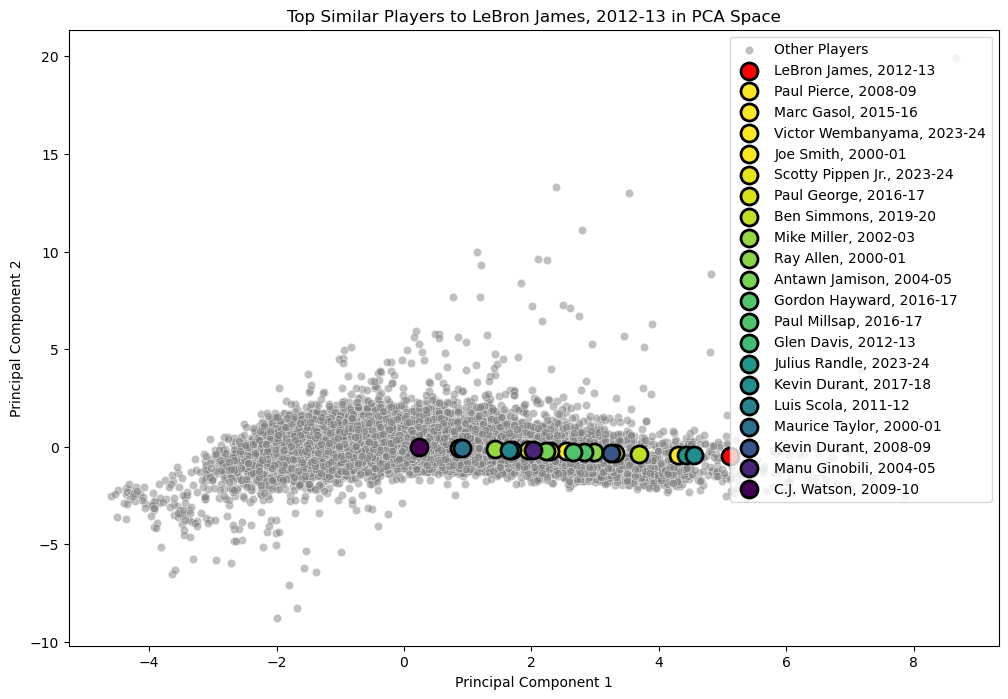

In [10]:
def visualize_similar_players(selected_player, similar_players, pca_df):
    # Extract the PCA coordinates of the selected player, get similarity score of the similar players, & normalize for colormap
    selected_player_coords = pca_df.loc[selected_player]
    similarity_scores = similar_players.values
    norm_similarity_scores = (similarity_scores - similarity_scores.min()) / (similarity_scores.max() - similarity_scores.min())
    
    # Create a scatter plot of all players in the PCA space
    plt.figure(figsize=(12, 8))
    sns.scatterplot(data=pca_df, x="PC1", y="PC2", color="gray", label="Other Players", alpha=0.5)

    # Plot the selected player in red
    plt.scatter(selected_player_coords["PC1"], selected_player_coords["PC2"], color="red", s=150, label=selected_player, edgecolor='black', linewidth=2)

    # Plot the most similar players with colormap
    for i, player in enumerate(similar_players.index):
        player_coords = pca_df.loc[player]
        
        # Assigning a color based on similarity using a colormap
        colormap = plt.cm.viridis
        color = colormap(norm_similarity_scores[i])
        
        plt.scatter(player_coords["PC1"], player_coords["PC2"], color=color, s=150, label=player, edgecolor='black', linewidth=2)

    plt.legend(loc="upper right")
    plt.title(f"Top Similar Players to {selected_player} in PCA Space")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")

    plt.show()

visualize_similar_players(player_name, similar_players, pca_df)

Now, we are able to determine Where the players are in relative location to our selected player.

## Part 4: Searching Other Players

Now that we have this information, we are able to keep this updated. For example, my favorite player of all time, Kemba Walker, had his best season in 2018-19. I would like to determine the most similar player to him for that season in the selected dataset.

Top 20 players similar to Kemba Walker, 2018-19:
 PLAYER
JR Smith, 2014-15             1.000000
Russell Westbrook, 2014-15    1.000000
Corey Maggette, 2011-12       1.000000
Marco Belinelli, 2017-18      1.000000
Tony Parker, 2006-07          1.000000
Jarrett Jack, 2011-12         1.000000
Vince Carter, 2010-11         1.000000
Mike Bibby, 2008-09           1.000000
Metta World Peace, 2001-02    0.999999
JR Smith, 2011-12             0.999999
Eric Paschall, 2020-21        0.999999
Trae Young, 2019-20           0.999999
John Stockton, 2000-01        0.999999
Joe Johnson, 2008-09          0.999999
Yogi Ferrell, 2017-18         0.999998
Joe Johnson, 2015-16          0.999998
Ja Morant, 2022-23            0.999997
Jason Kidd, 2007-08           0.999997
Jordan Clarkson, 2019-20      0.999997
Caris LeVert, 2020-21         0.999996
Name: Kemba Walker, 2018-19, dtype: float64


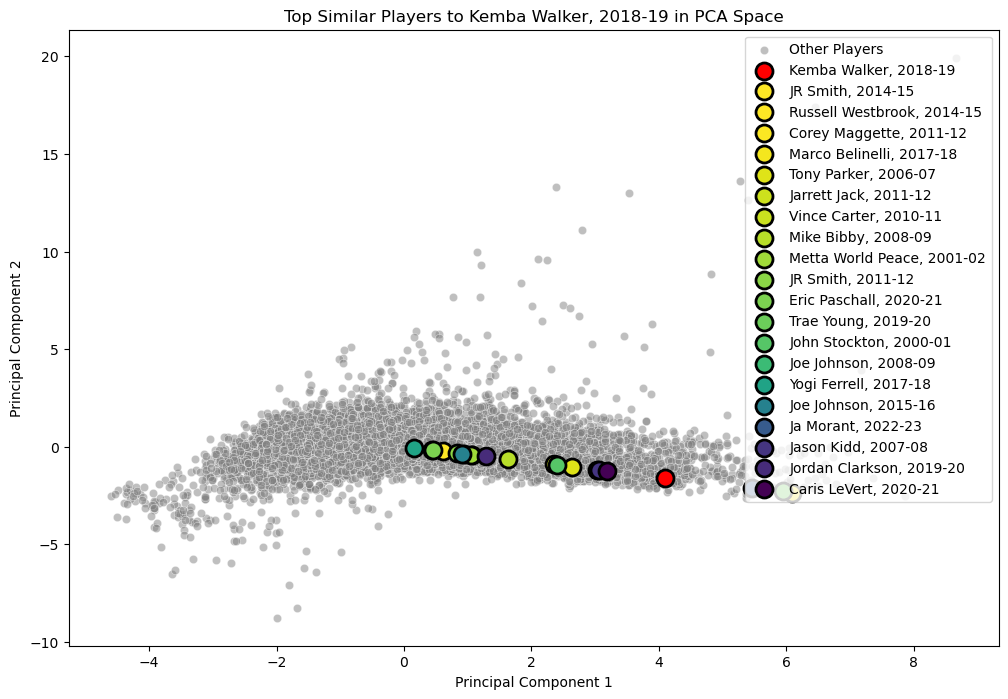

In [11]:
player_name = "Kemba Walker, 2018-19"
similar_players = get_similar_players(player_name, pca_df, top_n=20)

print(f"Top 20 players similar to {player_name}:\n", similar_players)

visualize_similar_players(player_name, similar_players, pca_df)

This is very interesting to see, as we can determine who the most similar players are for a certain season, to other seasons. However, when comparing this to everyone apart of this, it would be a stronger visualization to showcase a heatmap to see what this player and all the similar players have in common.

## Part 5: Heatmap Visualization

In [12]:
df.set_index('PLAYER', inplace=True)

In [13]:
def plot_normalized_stat_heatmap(selected_player, similar_players, df):
    
    players_to_compare = [selected_player] + list(similar_players.index)
    
    stats_columns = ["PTS", "REB", "AST", "TS_PCT", "USG_PCT", "PER"]
    comparison_df = df.loc[players_to_compare, stats_columns]
    
    # Normalize the data by dividing each stat by its maximum value
    normalized_df = comparison_df.copy()
    for stat in stats_columns:
        max_value = comparison_df[stat].max()
        normalized_df[stat] = comparison_df[stat] / max_value * 100  # Convert to percentage
    
    # Plot the heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(normalized_df.T, annot=False, cmap="Reds", cbar=True, fmt=".2f", linewidths=1)
    plt.title(f"Normalized Stat Heatmap: {selected_player} and Top Similar Players (as % of Max Value)")
    plt.xlabel("Players")
    plt.ylabel("Stats")
    
    plt.show()

In [14]:
def get_original_stat_list(selected_player, similar_players, df):
    
    players_to_compare = [selected_player] + list(similar_players.index)
    
    missing_players = [player for player in players_to_compare if player not in df.index]
    
    if missing_players:
        print(f"Warning: The following players were not found in the DataFrame: {missing_players}")
        players_to_compare = [player for player in players_to_compare if player not in missing_players]
    
    stats_columns = ["PTS", "REB", "AST", "TS_PCT", "USG_PCT", "PER"]
    comparison_df = df.loc[players_to_compare, stats_columns]
    
    # Convert the DataFrame to a list of dictionaries for easier readability
    stat_list = comparison_df.reset_index()
    stat_list = stat_list.rename(columns={'index': 'PLAYER'})

    return stat_list

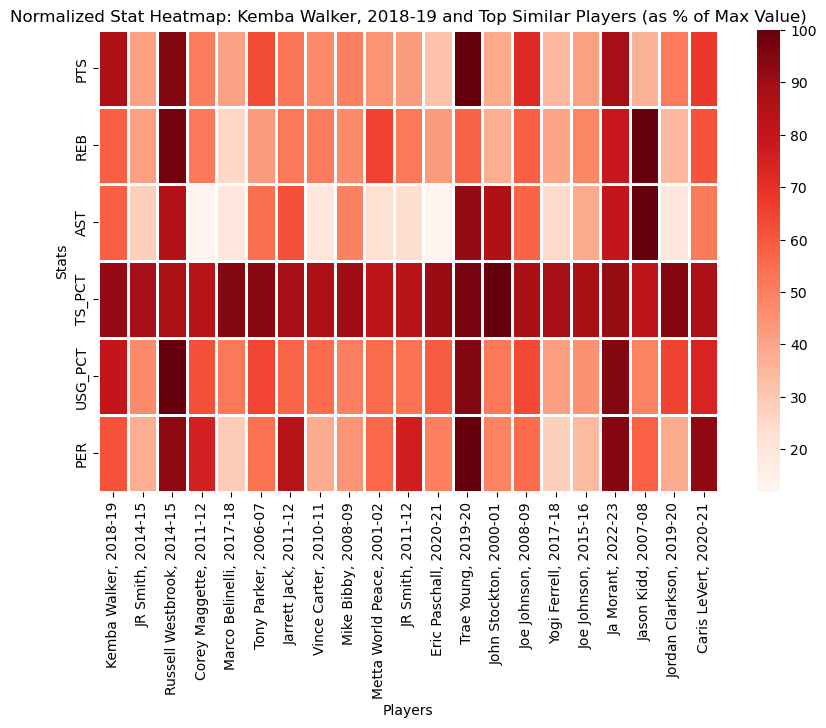

,PLAYER,PTS,REB,AST,TS_PCT,USG_PCT,PER
0,"Kemba Walker, 2018-19",25.6,4.4,5.9,0.553813,26.234002,0.273171
1,"JR Smith, 2014-15",12.1,3.1,2.8,0.536585,15.223345,0.165714
2,"Russell Westbrook, 2014-15",28.1,7.3,8.6,0.527106,32.509690,0.411940
3,"Corey Maggette, 2011-12",15.0,3.9,1.2,0.507185,20.310303,0.334375
4,"Marco Belinelli, 2017-18",12.1,1.9,1.9,0.573460,16.882030,0.127500
5,"Tony Parker, 2006-07",18.6,3.2,5.5,0.569243,21.020513,0.237662
6,"Jarrett Jack, 2011-12",15.6,3.9,6.3,0.535438,18.559804,0.373333
7,"Vince Carter, 2010-11",14.0,3.8,2.0,0.524738,17.931198,0.168493
8,"Mike Bibby, 2008-09",14.9,3.5,5.0,0.542015,16.251681,0.194937
9,"Metta World Peace, 2001-02",13.2,4.9,2.3,0.494104,17.994407,0.249091


In [15]:
plot_normalized_stat_heatmap(player_name, similar_players, df)
stat_list = get_original_stat_list(player_name, similar_players, df)
stat_list

In this specific case, we can see what is the biggest sell for this - It seems that each of these players, and why I enjoyed Kemba Walker so much that season, is due to the True Shooting Percentage and their ability to shoot the ball and have high efficiency. In our original Advanced Metrics computation:

**df["TS_PCT"] = df["PTS"] / (2 * (df["FGA"] + 0.44 * df["FTA"]))**

We can see that true shooting percentage is by taking the total points, dividing by the sum of field goals attempted and 4.4 times the free throws attempted. It mainly means they have good efficiency and can shoot free throws as well, which gives them more opportunities to attack the basket. Of course, this is not the highest true shooting percentage in the league - big men who have good free throw % usually have the highest. But, this does interest me in Shaquille O'Neal - someone who is known for attacking the basket, but notoriously known for being bad at free throws. However, It may be smarter to use more historical data for this section.

## Part 6: The Shaquille O'Neal Comparison

In this section, we will be using all of our previous code to showcase the functions laid before. There will be a bit of additional code, however, it will be mostly done in the previous sections.

Since Shaq started his career in 1992, lets go about 8 years back - lets begin in 1984. Shaq's biggest rival in his early years, Hakeem Olajuwon, was drafted this year, which makes it a good starting point. We will keep this all the way until current day, for now, just to have a good baseline for who compares well in the current stage.

In [16]:
nba_stats_df = get_nba_player_stats_multi_season(start_year=1984, end_year=2023)

C:\Users\Jonathan\AppData\Local\Temp\ipykernel_13336\1003339931.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat(all_seasons, ignore_index=True)


We do need to clean our file, still.

In [17]:
df = nba_stats_df

df['PLAYER'] = df['PLAYER_NAME'] + ', ' + df['SEASON']
df = df.drop(columns=['TEAM_ID', 'PLAYER_NAME', 'SEASON'])
df = df[['PLAYER'] + [col for col in df.columns if col != 'PLAYER']]

In [18]:
normalized_df = preprocess_data(df)
pca_df = apply_pca(normalized_df)

Lets go ahead and use the 1999-00 season - Shaq won the MVP this year. This does not mean it is his best season, however, it will provide a good argument for who compares to Shaq during his MVP season.

In [19]:
player_name = "Shaquille O'Neal, 1999-00"
similar_players = get_similar_players(player_name, pca_df, top_n=20)

print(f"Top 20 players similar to {player_name}:\n", similar_players)

Top 20 players similar to Shaquille O'Neal, 1999-00:
 PLAYER
Marvin Williams, 2006-07       1.000000
Tomas Satoransky, 2020-21      1.000000
Karl-Anthony Towns, 2020-21    1.000000
Aaron Gordon, 2016-17          1.000000
Ryan Anderson, 2015-16         1.000000
Joel Embiid, 2019-20           1.000000
Tim Duncan, 2008-09            1.000000
Paul Pierce, 1998-99           1.000000
Luke Walton, 2006-07           0.999999
Gordon Hayward, 2018-19        0.999999
Danny Manning, 1998-99         0.999999
Pau Gasol, 2012-13             0.999999
Bruce Brown, 2022-23           0.999998
Ruben Patterson, 2006-07       0.999998
Dirk Nowitzki, 2015-16         0.999997
Kristaps Porziņģis, 2021-22    0.999996
Carlos Boozer, 2012-13         0.999994
Jeff Hornacek, 1999-00         0.999993
David West, 2013-14            0.999991
Juwan Howard, 1998-99          0.999991
Name: Shaquille O'Neal, 1999-00, dtype: float64


These are extremely interesting choices. Not who I would have guessed. Marvin Williams, & Tomas Satoransky are interesting choices - However, a lot of the others are very on point. Tim Duncan, Paul Pierce, & Karl-Anthony Towns are great comparisons. Let's go ahead with the visualizations.

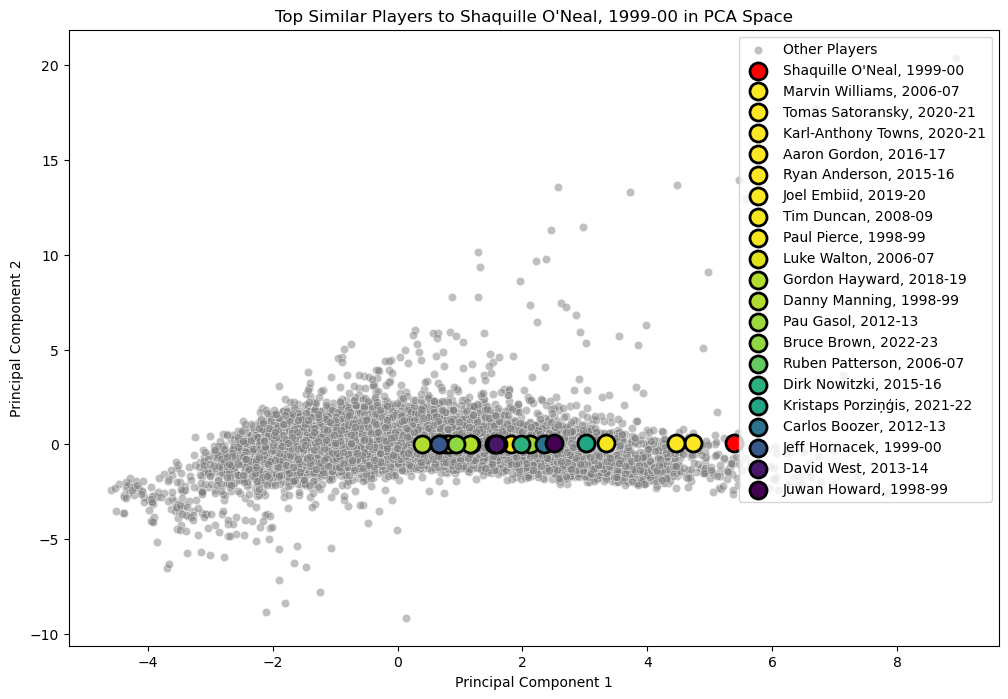

In [20]:
visualize_similar_players(player_name, similar_players, pca_df)

Let's go ahead and look at our finalized heatmap for Shaq and the players here.

In [21]:
df.set_index('PLAYER', inplace=True)

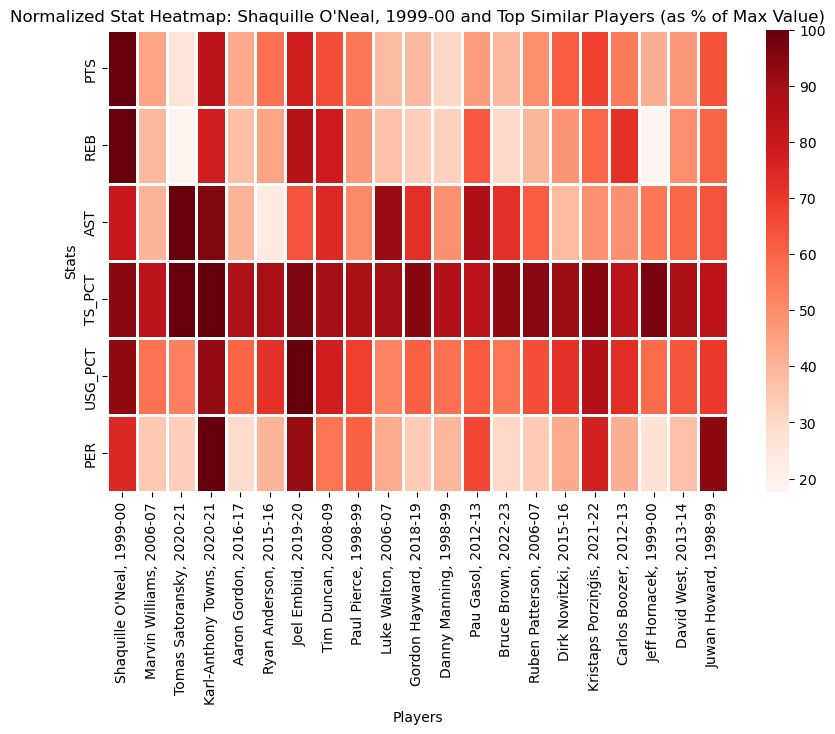

,PLAYER,PTS,REB,AST,TS_PCT,USG_PCT,PER
0,"Shaquille O'Neal, 1999-00",29.7,13.6,3.8,0.570276,24.713217,0.429114
1,"Marvin Williams, 2006-07",13.1,5.3,1.9,0.505889,15.128431,0.198437
2,"Tomas Satoransky, 2020-21",7.7,2.4,4.7,0.604870,14.173333,0.189655
3,"Karl-Anthony Towns, 2020-21",24.8,10.6,4.5,0.606505,24.569034,0.574000
4,"Aaron Gordon, 2016-17",12.7,5.1,1.9,0.525553,15.929152,0.166250
5,"Ryan Anderson, 2015-16",17.0,6.0,1.1,0.539255,19.082237,0.228788
6,"Joel Embiid, 2019-20",23.0,11.6,3.0,0.582647,26.587571,0.527451
7,"Tim Duncan, 2008-09",19.3,10.7,3.5,0.540919,20.742829,0.322667
8,"Paul Pierce, 1998-99",16.5,6.4,2.4,0.534067,18.133333,0.350000
9,"Luke Walton, 2006-07",11.4,5.0,4.3,0.545977,13.914141,0.243333


In [22]:
plot_normalized_stat_heatmap(player_name, similar_players, df)
stat_list = get_original_stat_list(player_name, similar_players, df)
stat_list

Again, this seems to have created a comparison for players who have a very similar TS% for Shaquille, but each of the other factors in this take into play well, as the gap is larger in comparison to Kemba Walker's from the previous experiment. The Usage Percentage, & PER are showcasing a lot of similarities especially with the ones that I mentioned before.

## Part 7: Showcase

Within this section of code, the only thing that needs changed is player_name. If you are wanting to change the years incorporated, run the first code block, otherwise, run code block two through seven.

In [23]:
nba_stats_df = get_nba_player_stats_multi_season(start_year=1984, end_year=2023)

C:\Users\Jonathan\AppData\Local\Temp\ipykernel_13336\1003339931.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat(all_seasons, ignore_index=True)


In [56]:
df = nba_stats_df

df['PLAYER'] = df['PLAYER_NAME'] + ', ' + df['SEASON']
df = df.drop(columns=['TEAM_ID', 'PLAYER_NAME', 'SEASON'])
df = df[['PLAYER'] + [col for col in df.columns if col != 'PLAYER']]

In [57]:
normalized_df = preprocess_data(df)
pca_df = apply_pca(normalized_df)

In [58]:
player_name = "Kawhi Leonard, 2014-15"
similar_players = get_similar_players(player_name, pca_df, top_n=20)

print(f"Top 20 players similar to {player_name}:\n", similar_players)

Top 20 players similar to Kawhi Leonard, 2014-15:
 PLAYER
Pau Gasol, 2017-18            1.000000
Pau Gasol, 2011-12            1.000000
Antawn Jamison, 1998-99       1.000000
Nikola Vučević, 2014-15       1.000000
Peja Stojakovic, 2002-03      0.999999
T.J. Warren, 2019-20          0.999999
Antawn Jamison, 2009-10       0.999999
Jaylen Brown, 2017-18         0.999999
Luis Scola, 2009-10           0.999999
Vlade Divac, 2000-01          0.999999
Jalen Williams, 2022-23       0.999998
Kevin Love, 2011-12           0.999998
Lonnie Walker IV, 2022-23     0.999998
James Harden, 2011-12         0.999997
Amar'e Stoudemire, 2011-12    0.999997
Boris Diaw, 2009-10           0.999997
Marcus Morris Sr., 2014-15    0.999996
Mehmet Okur, 2006-07          0.999996
Mehmet Okur, 2005-06          0.999995
Olden Polynice, 1996-97       0.999994
Name: Kawhi Leonard, 2014-15, dtype: float64


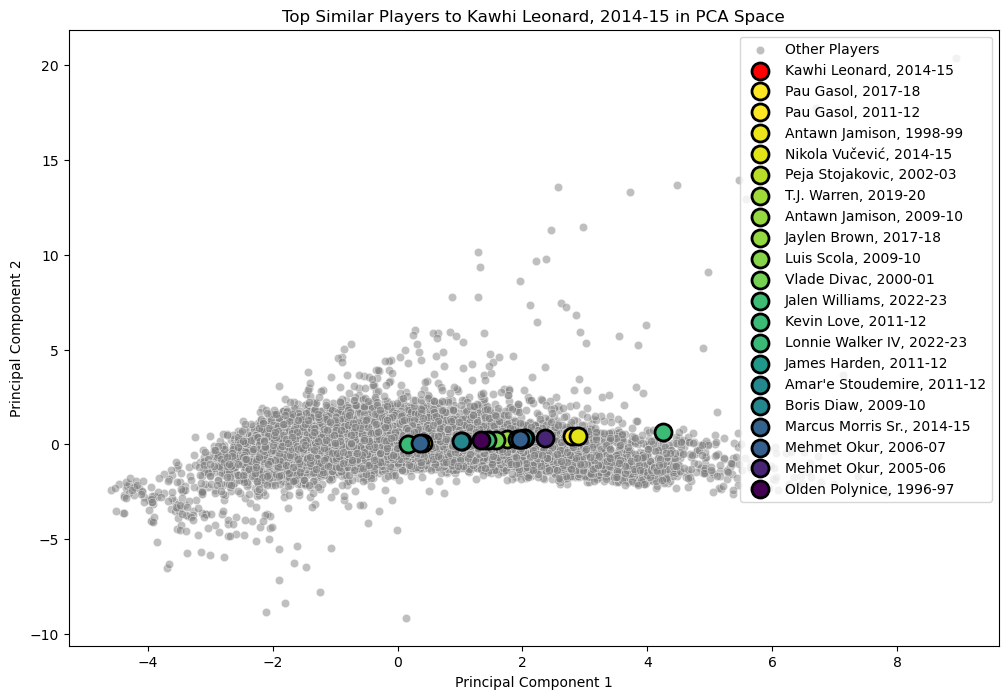

In [59]:
visualize_similar_players(player_name, similar_players, pca_df)

In [60]:
df.set_index('PLAYER', inplace=True)

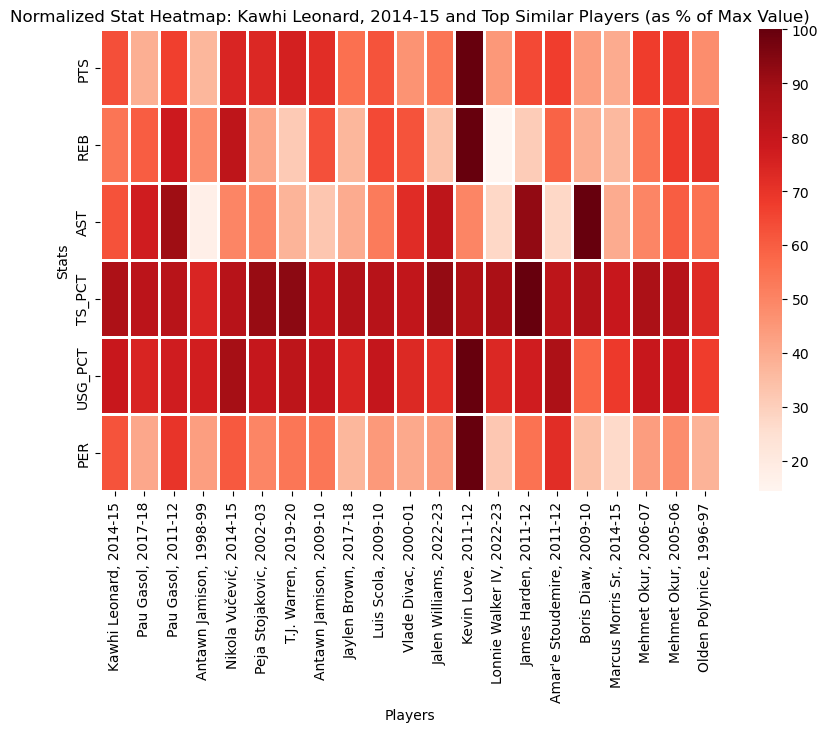

,PLAYER,PTS,REB,AST,TS_PCT,USG_PCT,PER
0,"Kawhi Leonard, 2014-15",16.5,7.2,2.5,0.563044,17.653040,0.320312
1,"Pau Gasol, 2017-18",10.1,8.0,3.1,0.538236,16.611348,0.209091
2,"Pau Gasol, 2011-12",17.4,10.4,3.6,0.543750,17.155080,0.358462
3,"Antawn Jamison, 1998-99",9.6,6.4,0.7,0.481565,17.011852,0.221277
4,"Nikola Vučević, 2014-15",19.3,10.9,2.0,0.545892,19.723197,0.312162
5,"Peja Stojakovic, 2002-03",19.2,5.5,2.0,0.594151,17.733333,0.255556
6,"T.J. Warren, 2019-20",19.8,4.2,1.5,0.606432,18.252280,0.276119
7,"Antawn Jamison, 2009-10",18.7,8.4,1.3,0.524177,17.816438,0.277273
8,"Jaylen Brown, 2017-18",14.5,4.9,1.6,0.554812,16.590662,0.188571
9,"Luis Scola, 2009-10",16.2,8.6,2.1,0.544813,17.837423,0.228049


In [61]:
plot_normalized_stat_heatmap(player_name, similar_players, df)
stat_list = get_original_stat_list(player_name, similar_players, df)
stat_list